Load dependencies and raw data

In [25]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.feature_selection import RFE
from sklearn.linear_model import LinearRegression, Ridge, Lasso
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error, r2_score
from xgboost import XGBRegressor
import warnings

warnings.filterwarnings('ignore')

# Load the data from octopus.xlsx
data = pd.read_excel('octopus.xlsx')

data.head()

,Type,Start Date,End Date,Price(£),Reading
0,Electricity,2024-08-31,2024-09-06,11.97,73718
1,Gas,2024-08-31,2024-09-06,4.37,38915
2,Electricity,2024-08-24,2024-08-30,13.08,73687
3,Gas,2024-08-24,2024-08-30,5.17,38912
4,Electricity,2024-08-17,2024-08-23,12.24,73652


define functions to preprocess data and EDA

In [26]:
# EDA and Data Preprocessing
def preprocess_data(df):
    # Convert dates to datetime
    df['Start Date'] = pd.to_datetime(df['Start Date'], format='%d-%b-%y')
    df['End Date'] = pd.to_datetime(df['End Date'], format='%d-%b-%y')
    
    # Calculate duration
    df['Duration'] = (df['End Date'] - df['Start Date']).dt.days
    
    # Encode Type
    le = LabelEncoder()
    df['Type_Encoded'] = le.fit_transform(df['Type'])
    
    # Extract additional features from dates
    df['Start_Month'] = df['Start Date'].dt.month
    df['Start_Day'] = df['Start Date'].dt.day
    df['End_Day'] = df['End Date'].dt.day
    df['End_Month'] = df['End Date'].dt.month
    
    return df

# Perform EDA
def perform_eda(df):
    print(df.describe())
    print("\nCorrelations:")
    print(df[['Duration', 'Price(£)', 'Reading', 'Type_Encoded', 'Start_Month', 'Start_Day', 'End_Day', 'End_Month']].corr())
    
    # Visualizations
    plt.figure(figsize=(12, 6))
    sns.heatmap(df[['Duration', 'Price(£)', 'Reading', 'Type_Encoded', 'Start_Month', 'Start_Day', 'End_Day', 'End_Month']].corr(), annot=True, cmap='coolwarm')
    plt.title('Correlation Heatmap')
    plt.show()

# Feature Selection
def select_features(X, y, n_features=5):
    rfe = RFE(estimator=LinearRegression(), n_features_to_select=n_features)
    rfe = rfe.fit(X, y)
    return X.columns[rfe.support_].tolist()

# Model Training and Evaluation
def train_and_evaluate_model(model, X_train, X_test, y_train, y_test, model_name):
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    mse = mean_squared_error(y_test, y_pred)
    r2 = r2_score(y_test, y_pred)
    print(f"{model_name} - MSE: {mse:.4f}, R2: {r2:.4f}")
    return model, mse, r2

In [27]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 88 entries, 0 to 87
Data columns (total 5 columns):
 #   Column      Non-Null Count  Dtype         
---  ------      --------------  -----         
 0   Type        88 non-null     object        
 1   Start Date  88 non-null     datetime64[ns]
 2   End Date    88 non-null     datetime64[ns]
 3   Price(£)    88 non-null     float64       
 4   Reading     88 non-null     int64         
dtypes: datetime64[ns](2), float64(1), int64(1), object(1)
memory usage: 3.6+ KB


                          Start Date                       End Date  \
count                             88                             88   
mean   2024-04-04 14:10:54.545454592  2024-04-11 02:43:38.181818112   
min              2023-10-13 00:00:00            2023-10-13 00:00:00   
25%              2024-01-25 06:00:00            2024-01-31 06:00:00   
50%              2024-04-03 12:00:00            2024-04-08 12:00:00   
75%              2024-06-16 18:00:00            2024-06-22 18:00:00   
max              2024-08-31 00:00:00            2024-09-06 00:00:00   
std                              NaN                            NaN   

        Price(£)       Reading   Duration  Type_Encoded  Start_Month  \
count  88.000000     88.000000  88.000000     88.000000    88.000000   
mean   14.548864  55851.443182   6.522727      0.500000     5.568182   
min     0.000000  38252.000000   0.000000      0.000000     1.000000   
25%     6.632500  38779.500000   6.000000      0.000000     3.000000   


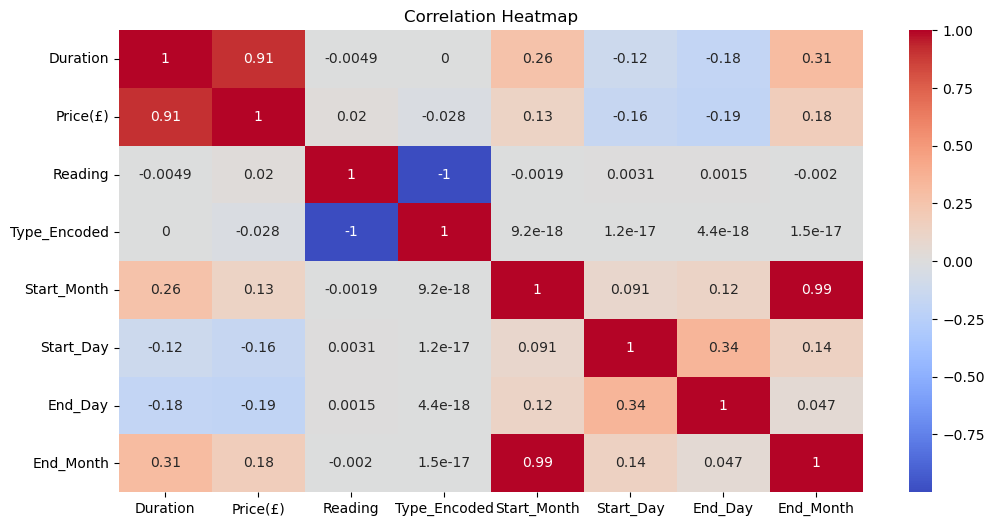

In [28]:
# Main execution
df = preprocess_data(data)
perform_eda(df)

In [29]:
# Prepare features and target
features = ['Duration', 'Price(£)', 'Type_Encoded', 'Start_Month', 'Start_Day', 'End_Day', 'End_Month']
X = df[features]
y = df['Reading']

# Feature selection
selected_features = select_features(X, y)
print("Selected features:", selected_features)

Selected features: ['Duration', 'Price(£)', 'Type_Encoded', 'Start_Month', 'Start_Day']


In [30]:
df.head()

,Type,Start Date,End Date,Price(£),Reading,Duration,Type_Encoded,Start_Month,Start_Day,End_Day,End_Month
0,Electricity,2024-08-31,2024-09-06,11.97,73718,6,0,8,31,6,9
1,Gas,2024-08-31,2024-09-06,4.37,38915,6,1,8,31,6,9
2,Electricity,2024-08-24,2024-08-30,13.08,73687,6,0,8,24,30,8
3,Gas,2024-08-24,2024-08-30,5.17,38912,6,1,8,24,30,8
4,Electricity,2024-08-17,2024-08-23,12.24,73652,6,0,8,17,23,8


In [31]:
X = X[selected_features]

# Split the data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Scale the features
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Train and evaluate models
models = {
    'Linear Regression': LinearRegression(),
    'Ridge Regression': Ridge(),
    'Lasso Regression': Lasso(),
    'Random Forest': RandomForestRegressor(random_state=42),
    'XGBoost': XGBRegressor(random_state=42)
}

results = {}

for name, model in models.items():
    trained_model, mse, r2 = train_and_evaluate_model(model, X_train_scaled, X_test_scaled, y_train, y_test, name)
    results[name] = {'model': trained_model, 'mse': mse, 'r2': r2}

Linear Regression - MSE: 203039.5827, R2: 0.9992
Ridge Regression - MSE: 309823.4066, R2: 0.9988
Lasso Regression - MSE: 202158.4147, R2: 0.9992
Random Forest - MSE: 7882.3646, R2: 1.0000
XGBoost - MSE: 6290.0844, R2: 1.0000


In [32]:
# Hyperparameter tuning for the best model
best_model_name = min(results, key=lambda x: results[x]['mse'])
print(f"\nBest model: {best_model_name}")

if best_model_name == 'Random Forest':
    param_grid = {
        'n_estimators': [50, 100, 200],
        'max_depth': [None, 10, 20, 30],
        'min_samples_split': [2, 5, 10],
        'min_samples_leaf': [1, 2, 4]
    }
    grid_search = GridSearchCV(RandomForestRegressor(random_state=42), param_grid, cv=3, scoring='neg_mean_squared_error')
    grid_search.fit(X_train_scaled, y_train)
    
    print("Best parameters:", grid_search.best_params_)
    best_model = grid_search.best_estimator_
    y_pred = best_model.predict(X_test_scaled)
    mse = mean_squared_error(y_test, y_pred)
    r2 = r2_score(y_test, y_pred)
    print(f"Optimized Random Forest - MSE: {mse:.4f}, R2: {r2:.4f}")

elif best_model_name == 'XGBoost':
    param_grid = {
        'n_estimators': [50, 100, 200],
        'max_depth': [3, 4, 5],
        'learning_rate': [0.01, 0.1, 0.3]
    }
    grid_search = GridSearchCV(XGBRegressor(random_state=42), param_grid, cv=3, scoring='neg_mean_squared_error')
    grid_search.fit(X_train_scaled, y_train)
    
    print("Best parameters:", grid_search.best_params_)
    best_model = grid_search.best_estimator_
    y_pred = best_model.predict(X_test_scaled)
    mse = mean_squared_error(y_test, y_pred)
    r2 = r2_score(y_test, y_pred)
    print(f"Optimized XGBoost - MSE: {mse:.4f}, R2: {r2:.4f}")


Best model: XGBoost
Best parameters: {'learning_rate': 0.3, 'max_depth': 3, 'n_estimators': 50}
Optimized XGBoost - MSE: 5936.5632, R2: 1.0000


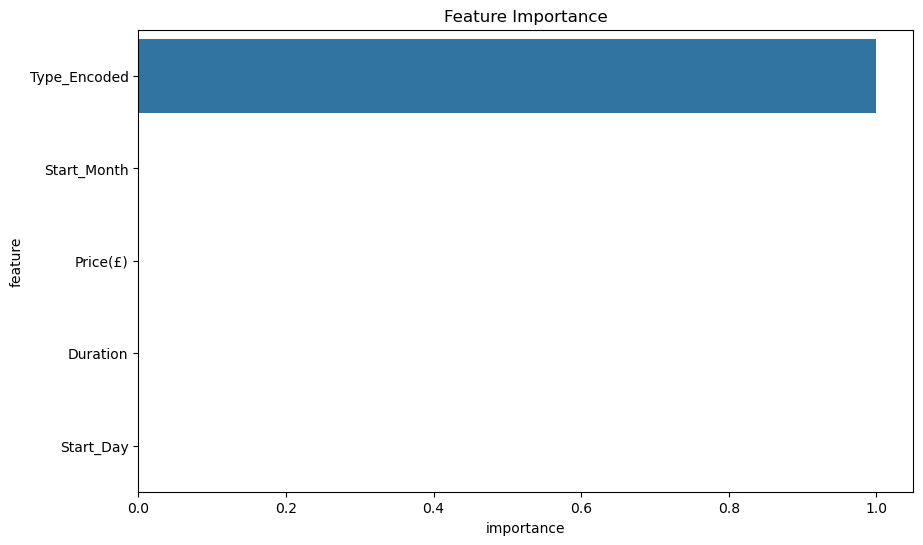

In [33]:
# Feature importance for the best model
if hasattr(best_model, 'feature_importances_'):
    importances = best_model.feature_importances_
    feature_importance = pd.DataFrame({'feature': selected_features, 'importance': importances})
    feature_importance = feature_importance.sort_values('importance', ascending=False)
    
    plt.figure(figsize=(10, 6))
    sns.barplot(x='importance', y='feature', data=feature_importance)
    plt.title('Feature Importance')
    plt.show()